# Installing Kaggle

In [ ]:
!pip install kaggle

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/"Kaggle API Credentials"/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

# Downloading flickr8k dataset using Kaggle Api

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:48<00:00, 24.1MB/s]
100% 1.04G/1.04G [00:48<00:00, 22.8MB/s]


In [ ]:
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

# Installing Dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
#defining directories
BASE_DIR = '/content/Images'
# WORKING_DIR = '/kaggle/working'

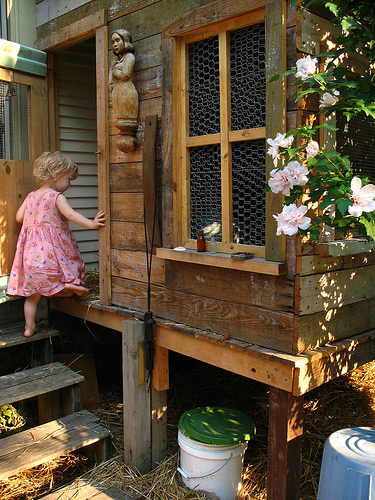

In [ ]:
#Displaying an image
from IPython.display import Image
Image('/content/Images/1000268201_693b08cb0e.jpg')

## Extracting Image Features using VGG16() model

In [ ]:
model = VGG16()
# This sets the output layer for the new model. It's extracting the output from the second-to-last layer of the existing model.
# i.e We are leaving the "Prediction (Dense)" layer of the VGG16 model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

# Image Feature Extraction using VGG16() Model



*   The provided code extracts image features using the VGG16 model pre-trained on the ImageNet dataset. These features can be used as inputs for a captioning model, enabling the model to generate captions for images.




In [ ]:
# Define a dictionary to store image features
features = {}

# Specify the directory containing the images
directory = os.path.join(BASE_DIR)

# Iterate through each image in the directory
for img_name in tqdm(os.listdir(BASE_DIR)):
    # Load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for VGG
    image = preprocess_input(image)

    # Extract features using the pre-trained model
    feature = model.predict(image, verbose=0)

    # Get image ID from the filename
    image_id = img_name.split('.')[0]

    # Store extracted features in the dictionary
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# Store features in pickle
WORKING_DIR='/content/drive/MyDrive/Sem 6 Projects/AI Project/saved_models'
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
#Load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Loading Captions Data

In [ ]:
BASE_DIR1 = '/content/captions.txt'
with open(BASE_DIR1, 'r') as f:
    next(f)
    captions_doc = f.read()

# Mapping Image IDs to Captions



*   This code snippet demonstrates how to create a mapping of image IDs to captions by processing a document containing image captions.



In [ ]:
# Create an empty dictionary to store the mapping of image IDs to captions
mapping = {}

# Iterate through each line in the 'captions_doc'
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')

    # Check if the line has enough elements (at least 2)
    if len(line) < 2:
        continue
    # Extract the image ID and caption from the tokens
    image_id, caption = tokens[0], tokens[1:]

    # Remove extension from image ID
    image_id = image_id.split('.')[0]

    # Convert the caption list to a string by joining its elements
    caption = " ".join(caption)

    # Create a list if the image ID is not already in the mapping dictionary
    if image_id not in mapping:
        mapping[image_id] = []

    # Store the caption in the list associated with the image ID
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

# Cleaning Captions in the Mapping

*   This function cleans the captions associated with each image ID in the provided mapping dictionary. It performs various preprocessing steps to standardize and prepare the captions for further processing, such as training a neural network for image captioning.


In [ ]:
def clean(mapping):

    # Iterate through each key-value pair in the 'mapping' dictionary
    for key, captions in mapping.items():

        # Iterate through each caption associated with the current key
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]

            # Preprocessing steps for the caption:

            # Convert the caption to lowercase
            caption = caption.lower()

            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')

            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Gathering All Captions


1.   This code snippet collects all captions from the provided mapping dictionary
2.   Stores them in a list named all_captions
3. This aggregated list can be useful for further processing, such as building a vocabulary or training a language model.



In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
print(len(all_captions))
print()
print(all_captions[:10])

40455

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


# Tokenizing Text Data


*   In this code snippet, a Tokenizer object is created to handle text tokenization. The provided all_captions data is used to fit the tokenizer, which analyzes the text to identify unique words (building a vocabulary) and assigns a unique integer ID to each word.



In [ ]:
# Create a tokenizer object to handle text tokenization
tokenizer = Tokenizer()

# Fit the tokenizer on the provided text data (all_captions)
# This process:
#   - Analyzes the text to identify unique words (vocabulary)
#   - Assigns a unique integer ID to each word
tokenizer.fit_on_texts(all_captions)

# Calculate the vocabulary size (number of unique words) plus 1
# The extra 1 accounts for the 0-th index, which is often reserved for padding
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Spli


*   The provided code splits a list of image IDs into train and test sets for training and evaluation purposes in a machine learning pipeline.


In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Data Generator for Training


*   The provided code defines a data generator function data_generator to yield batches of training data. This generator helps avoid memory issues by loading and processing data in batches, preventing the session from crashing due to memory overload.



In [ ]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    # Initialize empty lists to store data
    X1, X2, y = list(), list(), list()

    n = 0 # Counter for tracking batch size

    while 1: # Infinite Loop to yield batches

        for key in data_keys: # Iterate through each image key
            n += 1

            captions = mapping[key]  # Retrieve captions associated with the image

            # process each caption
            for caption in captions:

            # Tokenize the caption into a sequence of integer IDs
                seq = tokenizer.texts_to_sequences([caption])[0]

                # Split the sequence into multiple X, y pairs for training
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # One-Hot Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            # If a batch is complete, yield it and reset
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y) # Convert to NumPy arrays
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()  # Reset lists for the next batch
                n = 0  # Reset counter

# Image Captioning Model Architecture with Encoder-Decoder Network

* **Encoder Layers:** These layers handle the input data, which includes both image features and text sequences.
* **Image Feature Layers:** These layers process the extracted features from images.
The input is a vector of length 4096 representing image features.
A dropout layer is applied for regularization.
A dense layer with 256 units and ELU activation is used to further process the features.
* **Sequence Feature Layers:** These layers process the input text sequences.
The input is a sequence of integers representing words, with padding to ensure uniform length.
An embedding layer converts each word index into a dense vector representation.
A dropout layer is applied for regularization.
An LSTM layer with 256 units is used to capture sequential information from the text.
* **Decoder Layers:** These layers combine the features from the encoder and generate output predictions.
The features from the image and sequence encoders are combined using an addition operation.
The combined features pass through a dense layer with 256 units and ELU activation.
The final output layer produces a probability distribution over the vocabulary using a softmax activation function.


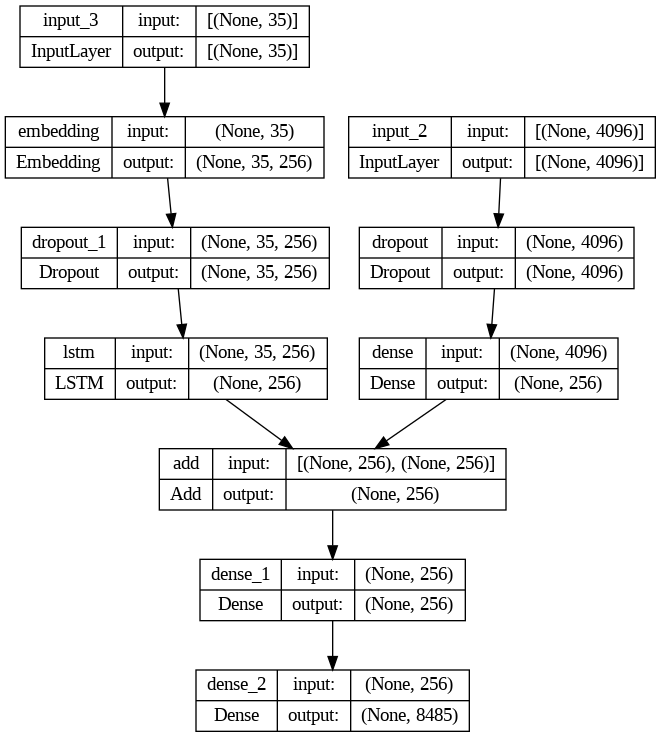

In [ ]:
# Encoder Layers:-

# Image feature layers:
inputs1 = Input(shape=(4096,)) # Input for image features (4096 dimensions)
fe1 = Dropout(0.2)(inputs1) # Apply dropout for regularization
fe2 = Dense(256, activation='elu')(fe1) # Dense layer with ReLU activation

# Sequence feature layers:
inputs2 = Input(shape=(max_length,)) # Input for text sequences
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) # Word embedding layer
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2) # LSTM layer to model sequential information

# Decoder layers:-
decoder1 = add([fe2, se3]) # Combine image and sequence features
decoder2 = Dense(256, activation='elu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2) # Output layer with softmax for word probabilities

model = Model(inputs=[inputs1, inputs2], outputs=outputs) # Define model with two inputs and one output
model.compile(loss='categorical_crossentropy', optimizer='adam')


# Plot the model
plot_model(model, show_shapes=True)

# Training the Image Captioning Model

In [ ]:
# train the model
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 69s 302ms/step - loss: 1.9387


In [ ]:
model_path = "/content/drive/MyDrive/Sem 6 Projects/AI Project/saved_models/model_2_.h5"

# Save the model
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Replace 'your_model_path' with the path to your saved model file
loaded_model = load_model('/content/drive/MyDrive/Sem 6 Projects/AI Project/saved_models/model_2_.h5')

# Converting Token IDs to Words

*  In natural language processing tasks, it's often necessary to convert numerical token IDs back to their corresponding words. This function, idx_to_word, achieves exactly that. Given an integer representing a token ID and the tokenizer object used to tokenize the text, this function returns the word corresponding to the integer ID. If the ID is not found in the tokenizer's vocabulary, it returns None.

In [ ]:
def idx_to_word(integer, tokenizer):
    """
    Converts a numerical token ID back to its corresponding word using a tokenizer.

    Args:
        integer: The integer ID representing the word.
        tokenizer: The tokenizer object that was used to tokenize the text.

    Returns:
        The word corresponding to the integer ID, or None if the ID is not found.
    """

    # Iterate through the tokenizer's vocabulary
    for word, index in tokenizer.word_index.items():
        # If the integer ID matches the index of a word, return the word
        if index == integer:
            return word

    # If no matching word is found, return None
    return None

# Generating Caption for an Image

*  This function, predict_caption, generates a caption for an input image using a pre-trained image captioning model.



In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):

    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):

       # Tokenize the current caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # pad the sequence
        sequence = pad_sequences([sequence], max_length)

        # predict next word
        yhat = model.predict([image, sequence], verbose=0)

        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)

        # convert index to word
        word = idx_to_word(yhat, tokenizer)

        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

# Evaluating Model Performance with BLEU Score



*  The provided code segment validates the image captioning model with the test data and calculates the BLEU score, a common metric for evaluating the quality of generated captions.



In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.527794
BLEU-2: 0.298381


# Testing Model

*   The provided function generate_caption(image_name) generates a caption for a given image and compares it with the actual captions associated with the image.


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy smiles underwater endseq
startseq red-headed boy swimming underwater endseq
startseq small boy swimming underwater endseq
startseq smiling boy swims underwater in pool endseq
startseq the boys smiles underwater at the pool endseq
--------------------Predicted--------------------
startseq the boy is swimming underwater endseq


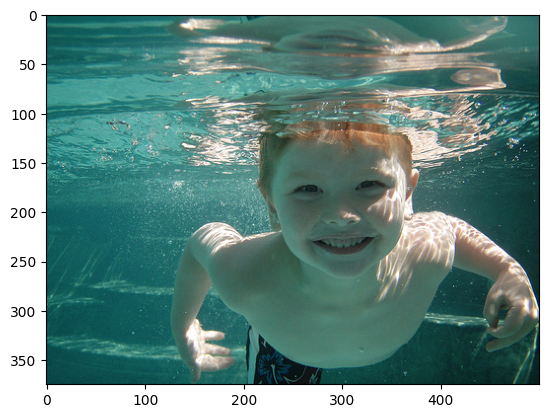

In [ ]:
generate_caption("1096165011_cc5eb16aa6.jpg")

---------------------Actual---------------------
startseq people on atvs and dirt bikes are traveling along worn path in field surrounded by trees endseq
startseq three people are riding around on atv 's and motorcycles endseq
startseq three people on motorbikes follow trail through dry grass endseq
startseq three people on two dirt-bikes and one four-wheeler are riding through brown grass endseq
startseq three people ride off-road bikes through field surrounded by trees endseq
--------------------Predicted--------------------
startseq three people are riding tricycles endseq


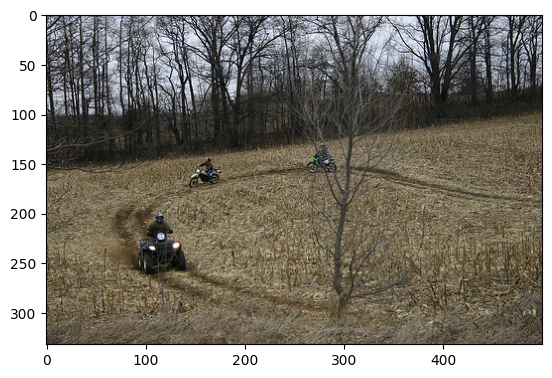

In [ ]:
generate_caption("112243673_fd68255217.jpg")

---------------------Actual---------------------
startseq two children are laughing in the grass endseq
startseq two girls laughing outside in yard endseq
startseq two girls standing on grass face each other endseq
startseq two young girls are playing and laughing in green grassy yard endseq
startseq two young girls playing together endseq
--------------------Predicted--------------------
startseq little girl in pink dress points backwards she endseq


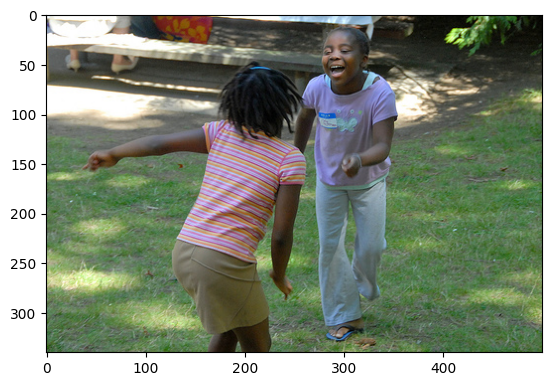

In [ ]:
generate_caption("1220401002_3f44b1f3f7.jpg")

---------------------Actual---------------------
startseq little boy stands in the surf endseq
startseq small child wades through the water while being guided by another person endseq
startseq young boy laughs while splashing in the ocean endseq
startseq young boy wearing colorful bathing suit splashing in the ocean endseq
startseq young child splashing in water endseq
--------------------Predicted--------------------
startseq two young girls in pink bathing suits are playing in the pool endseq


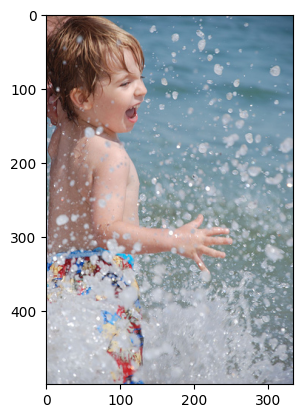

In [ ]:
generate_caption("1118557877_736f339752.jpg")

---------------------Actual---------------------
startseq two constructions workers sit on beam taking break endseq
startseq two construction workers are sitting up on the side of building endseq
startseq two construction workers sitting on an i-beam endseq
startseq two construction workers take seat on steel beam endseq
startseq two men take break from construction endseq
--------------------Predicted--------------------
startseq two construction workers are sitting on construction stairs endseq


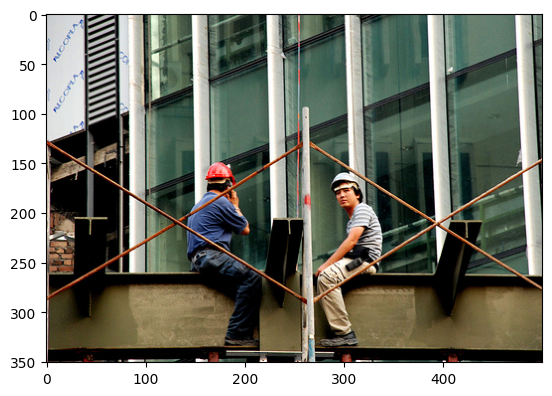

In [ ]:
generate_caption("1055753357_4fa3d8d693.jpg")

## Testing with New Images and generating a new Caption for an image



*   This function allows users to generate new captions for images using a pre-trained image captioning model.
*   It serves as a tool for generating textual descriptions of images, which can be useful in various applications such as image indexing, retrieval, and accessibility.



In [ ]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def new_caption(image_path, model, tokenizer, max_length):
    """
    Generates a caption for an image using a trained image captioning model.

    Args:
        image_path (str): Path to the image file.
        model: The trained image captioning model.
        tokenizer: The tokenizer used to encode text for the model.
        max_length: The maximum length of the generated caption.

    Returns:
        str: The generated caption.
    """

    # Load VGG16 model and restructure it to output features from the second-to-last layer
    vgg_model = VGG16()
    vgg_model = keras.models.Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

    # Display the image
    img = load_img(image_path)
    plt.imshow(img)

    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features from the image using VGG16
    feature = vgg_model.predict(image, verbose=0)

    # Generate caption using the trained model
    caption = predict_caption(model, feature, tokenizer, max_length)

    return caption


In [ ]:
! kaggle datasets download -d neilanshchauhan/image-caption-test-v2-0

100% 465k/465k [00:00<00:00, 646kB/s]
100% 465k/465k [00:00<00:00, 645kB/s]


In [ ]:
! unzip image-caption-test-v2-0.zip

Archive:  image-caption-test-v2-0.zip
  inflating: boy_cycle.jpg           
  inflating: cafe.jpg                
  inflating: children_playing.jpg    
  inflating: dirt bike.jpg           
  inflating: dog-playtime-927x388.jpg  
  inflating: dog1.jpg                
  inflating: handstand.jpg           
  inflating: hill_climb.jpg          
  inflating: kid_smiling.jpg         
  inflating: sitting_bench.jpg       


In [ ]:
from tensorflow.keras.models import load_model

# Replace 'your_model_path' with the path to your saved model file
loaded_model = load_model('/content/drive/MyDrive/Sem 6 Projects/AI Project/saved_models/model_2_.h5')

'startseq man sits on bench eating soda endseq'

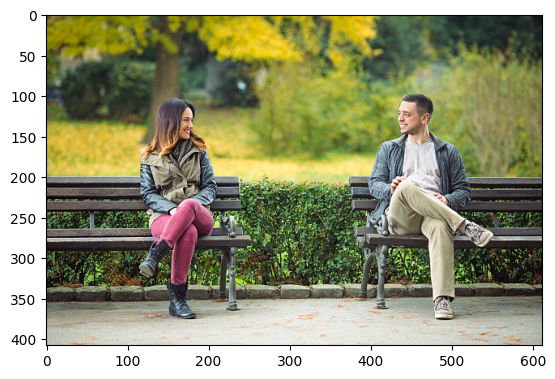

In [ ]:
new_caption("/content/sitting_bench.jpg",loaded_model,tokenizer,max_length)

'startseq girl in pink shirt stepping on pink inflatable ball endseq'

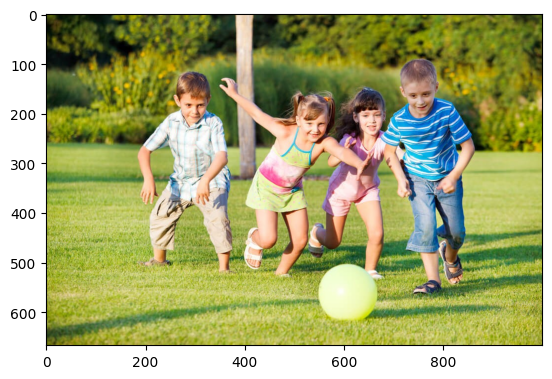

In [ ]:
new_caption("/content/children_playing.jpg",model,tokenizer,max_length)

'startseq man in black jacket and sunglasses is standing next to coffee door endseq'

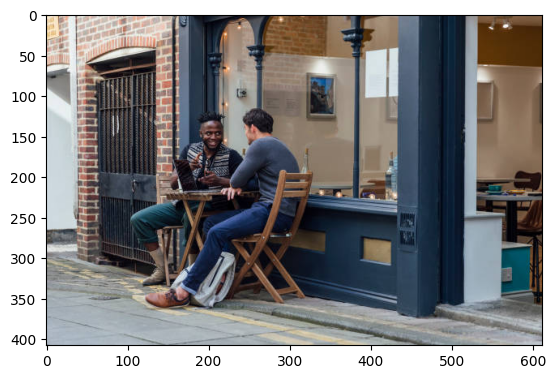

In [ ]:
new_caption("/content/cafe.jpg",model,tokenizer,max_length)

'startseq two dogs running through the sprinkler endseq'

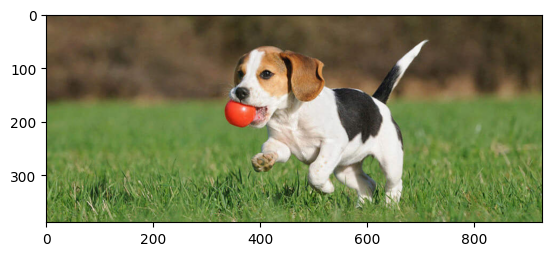

In [ ]:
new_caption("/content/dog-playtime-927x388.jpg",model,tokenizer,max_length)

'startseq man rides dirt bike through river endseq'

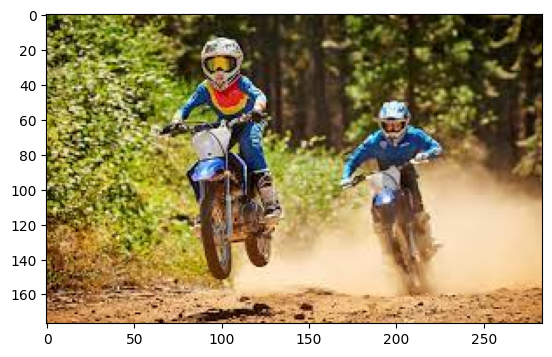

In [ ]:
new_caption("/content/dirt bike.jpg",model,tokenizer,max_length)

'startseq girl in pink print print shirt blowing onto dandelion endseq'

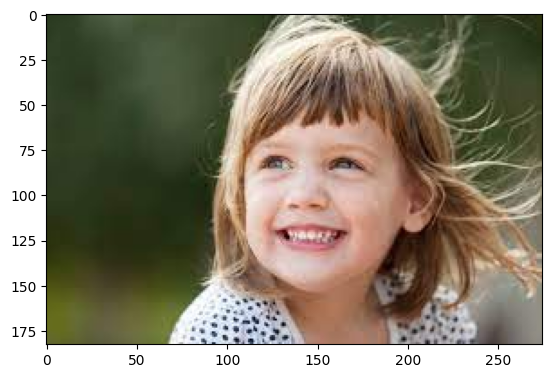

In [ ]:
new_caption("/content/kid_smiling.jpg",model,tokenizer,max_length)

## The model is generating decent captions. Although it is not highly accurate, but still it is able to capture details of the image and is generating text related to it. If we feed our model with more data, our caption will be more accurate (We can use Flickr30k dataset,or try out with other pretrained models like => ResNet, Inception, Xception)

In [ ]:
from tensorflow.keras.models import load_model

# Replace 'your_model_path' with the path to your saved model file
loaded_model = load_model('/content/drive/MyDrive/Sem 6 Projects/AI Project/saved_models/model_2_.h5')

'startseq girl in pink shirt stepping on pink inflatable ball endseq'

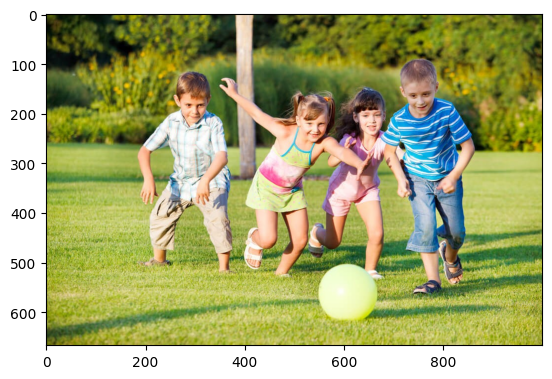

In [ ]:
new_caption("/content/children_playing.jpg",loaded_model,tokenizer,max_length)

# Generating Image from the Caption

This code utilizes the Hugging Face libraries to generate an image from a given caption using a diffusion model.

* First, it generates a caption for an image using a pre-trained model and tokenizer.

* Then, it employs the StableDiffusionPipeline from the diffusers library, using the Hugging Face model "dreamlike-art/dreamlike-diffusion-1.0" to generate an image based on the generated caption.

Finally, it displays the generated image using matplotlib.

startseq girl in pink shirt stepping on pink inflatable ball endseq


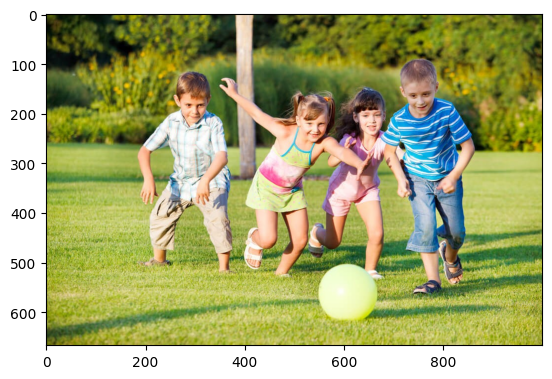

In [ ]:
# Generate a caption for an image and store it in a variable
generated_caption = new_caption("/content/children_playing.jpg", loaded_model, tokenizer, max_length)

# Now 'generated_caption' variable contains the generated caption
print(generated_caption)


In [ ]:
print(generated_caption)

startseq girl in pink shirt stepping on pink inflatable ball endseq


In [ ]:
!pip install diffusers
import tensorflow as tf
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

In [ ]:
model_id1 = "dreamlike-art/dreamlike-diffusion-1.0"
pipe = StableDiffusionPipeline.from_pretrained(model_id1)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
generated_caption = "girl in pink shirt stepping on pink inflatable ball"

In [ ]:
prompt=generated_caption

  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  girl in pink shirt stepping on pink inflatable ball


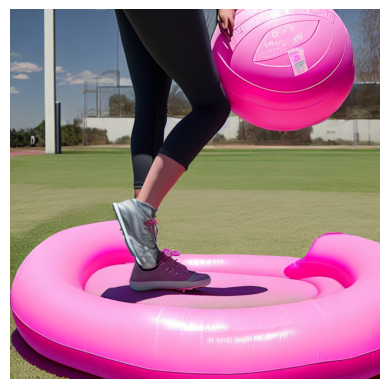

In [ ]:
image = pipe(prompt).images[0]
print("[PROMPT]: ", prompt)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
generated_caption = "the boy is swimming underwater"

In [ ]:
prompt=generated_caption

  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  the boy is swimming underwater


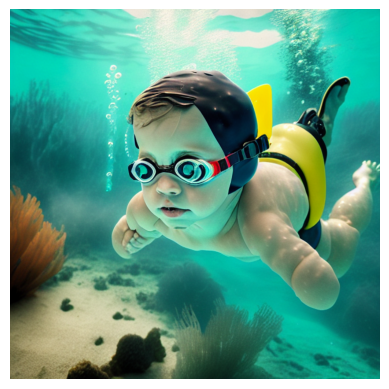

In [ ]:
image = pipe(prompt).images[0]
print("[PROMPT]: ", prompt)
plt.imshow(image)
plt.axis('off')
plt.show()

# Thus, we are generating images from caption